# UrbanHeatOpt

The provided Jupyter notebook supports a streamlined workflow for acquiring input data, generating spatially and temporally resolved heat demand profiles, and optimizing heating system concepts for urban and regional energy planning.

Before starting, ensure that all dependencies are installed and the appropriate Python environment is activated.

Comprehensive setup instructions and user documentation are available in the [official documentation](https://iee-tugraz.github.io/UrbanHeatOpt/).


In [2]:
# import the modules that are used in the script
import prepare_geodata
import hd_time_series_generator
import clustering
import model
import visualisation

### Define a Case Study and Specify the Location

Each analysis begins by creating a new case study. This includes assigning a unique name and selecting a geographic region of interest. The region can be defined either by a place name (e.g., "Graz, Austria") or by a custom polygon, such as a circular area defined by a center coordinate and radius. This spatial input forms the basis for all subsequent data processing and modeling.


In [3]:
# get the data from OSM
case_study_name = "Fehring"
# you can either use the name, if this region exits in OSM
location = "Fehring, Styria, Austria"
# OR 
# you can use the coordinates of the bounding box
polygon = prepare_geodata.polygon_by_circle(47.99, 12.00, 3)


### Generate a Geodataset

Once the case study is defined, the next step is to generate a geospatial dataset of all relevant buildings in the selected area. This includes downloading building footprints form OpenStreetMaps, estimating geometry-based attributes, and enriching them with energy-related data. The result is a GeoDataFrame containing all necessary input for heat demand modeling and network analysis.
The Buildingn Typology is defined in the `Building_Typology.csv` file. You can adjust this file to customize for the case study region.

In [4]:
# generate a complete geodataset for the case study
gdf_buildings = prepare_geodata.generate_complete_geodataset(case_study_name, location)

Case study Fehring folder exists already
Start: Retrieving geodata for: Fehring, Styria, Austria
Done: Geodata for Fehring, Styria, Austria successfully retrieved.
Start: Extracting relevant data from the raw geodata
Added addr:city
Added addr:postcode
Added addr:street
Added addr:housenumber
Added building
Added building:levels
Added height
Done: Relevant data extracted from the raw geodata
Start: Processing data for building classification
Data availability for year of construction: 0.00 %
Data availability for projected ground area: 100.00 %
Data availability for number of floors: 0.11 %
Average number of floors: 1.58
Maximum number of floors: 4.00
Data availability for number of dwellings: 0.00 %
Done: Data processing for building classification
Done: Removed 0 buildings with a projected area of zero
Done: Building data written to disk


In [5]:
# check the heat demand in the area
visualisation.plot_HD_interactive(gdf_buildings)

### Time Series Generation

Before generating heat demand time series, ensure the following input files are adapted to match the specific case study context:

- **`outside_temp.xlsx`**  
  Contains the hourly outside temperature for one year (8760 values). This data has a strong influence on the heating demand and should reflect the local climate conditions of the case study area.

- **`solar_gain.xlsx`**  
  Provides hourly average global solar irradiation (in W/m²) for the same time period. This is used to estimate solar gains per building, scaled by building-specific parameters.

- **`transition_matrix_WD.xlsx`** and **`transition_matrix_WE.xlsx`**  
  Define stochastic user behavior patterns on workdays and weekends, respectively. These 10-minute resolution transition matrices are used to generate realistic active occupancy profiles.

> While outside temperature and solar gain must be location-specific due to their significant impact on the simulation, the default transition matrices offer reasonable approximations for many regions and do not necessarily require customization unless user behavior is expected to differ significantly.


In [6]:
# generate heat demand time series for all buildings
df_HD_time_series = hd_time_series_generator.fast_TS_generator(case_study_name, True)

Start processing for case study:  Fehring
Done: load config
Done: load transition matrix
Done: load temperature data
Done: load building data
Start generating time series for: 15656 dwellings. Estimated computational time is: 41.0 seconds.
Done: generate time series
Max deviation on single building level: 94.27 %
Total deviation in heat demand: 13.22 %
Write time series to disk
Done: write time series to disk


### Clustering

In this step, buildings are grouped into heat demand clusters, candidate heat generation units are integrated, and a potential district heating network layout is proposed. Before running the clustering process, ensure the following files are correctly configured in the `input` folder of the respective scenario:

- **`input_HeatGenerationUnits.xlsx`**  
  Specifies all potential heat sources, such as waste heat units, boilers, and thermal energy storage (TES). Each entry defines the unit type, location (`lat`, `lon`), investment and operational costs, and capacity characteristics.

- **`input_WasteHeatProfiles.xlsx`**  
  Contains the hourly availability profiles (mass flow or capacity) for each waste heat unit listed in `input_HeatGenerationUnits.xlsx`. Each column must correspond to a unit name and contain 8760 values (one per hour).

- **`input_ParameterCosts.xlsx`**  
  Defines key parameters and cost assumptions relevant to clustering, including:
  - `param_cluster_size`: Number of buildings per heat demand cluster  
  - Pipe investment parameters: fixed (`pPipeCostIni`) and variable (`pPipeCostsSlope`) costs  
  - Grid connection costs: per building, per area, and per kW of installed power

#### Running and Comparing Multiple Scenarios

To compare different configurations or parameter assumptions (e.g. waste heat availability, cost variations, or clustering sizes), duplicate the existing scenario folder, modify the relevant input files in the new folder, and rerun the clustering step. This approach supports consistent and traceable scenario-based analysis within a single case study.



In [7]:
# cluster everything
scenario_name = "base"
clustering.perform_complete_clustering(case_study_name, scenario_name)

Scenario folder exists already
Start: load heat generation units from: Fehring\scenarios\base\input
                   Parameter       Value
0                   pCostHNS  100.000000
1               pCostPumping    0.000001
2                   pTsupply   55.000000
3                   pTreturn   35.000000
4               pPipeCostIni   32.000000
5               pMassFlowIni    0.600000
6            pPipeCostsSlope    0.018000
7         param_cluster_size   80.000000
8   cost_DH_connect_building    8.500000
9       cost_DH_connect_area    0.000040
10     cost_DH_connect_power    6.500000
11    daily_hot_water_demand    3.000000
12      allow_double_heating    0.000000
Start: load building for case study: Fehring
Done: load building data
Start: load heat generation units from: Fehring\scenarios\base\input
Done: load heat generation units
Done: load waste heat profiles
Start: calculate centroids
Done: calculate centroids
Start: cluster buildings into 80 clusters
Done: cluster buildings
Star

### Optimization Model

This step executes the techno-economic optimization model. Based on the clustered demand, candidate heat generation units, and cost parameters, the model determines the optimal configuration and operation of the district heating network.

#### Purpose

The optimization model selects and sizes:

- Heat generation units (e.g., waste heat, boilers, thermal energy storage)
- Network layout and pipe dimensions
- Operational dispatch for each time step
- Building connections and associated investments

It minimizes total system cost, including investment and operation, while meeting all thermal demand constraints.


#### Running and Analyzing

Once all input files are properly configured, you can run the optimization model using the script (`model.py`) or the interactive notebook (`main.ipynb`). The results — including system layout, unit dispatch, investment decisions, and cost breakdowns — are saved in the `output/` folder of the respective scenario.

During execution, the console will display solver progress and status updates.  
> ⏱️ **Note:** Solving time can vary significantly depending on the model complexity and scenario size — from several minutes for small cases to multiple hours for larger, more detailed configurations.


In [8]:
# performa a optimisation
model.run_model(case_study_name, scenario_name)

Loading data from:  Fehring\scenarios\base\data\heat_network
Done: create heat network dictionary
Time:  0.003300189971923828
Done: add parameters
Time:  0.0035936832427978516
Done: created heat demand dictionary
Time:  16.021931409835815
Done: add heat demand data
Time:  4.2510199546813965
Done: add heat generation dictionaries
Time:  0.6095442771911621
Done: add heat generation parameters
Time:  0.1688060760498047
Done: add variables
Time:  9.800039768218994
Done: add objective function
Time:  24.755903244018555
Done: add energy balance
Time:  25.314139127731323
Done: add max dh power
Time:  10.013038635253906
Done: add mf balance
Time:  32.86489391326904
Done: add mf injection
Time:  22.916523933410645
Info: No decentral heating allowed when building connected to the network
Done: add decentral condition
Time:  10.573599338531494
Done: add max wh power
Time:  0.572437047958374
Done: add tes production
Time:  0.15710973739624023
Done: add max power invest
Time:  0.2667872905731201
Do

### Visualization

This step generates three key plots based on the optimization results:

1. **Investment Decisions** — Georeferenced map of all investment decisions, including unit placements and network layout.
2. **Annual Energy Balance** — Summary of yearly heat generation, disaggregated by generation unit type.
3. **Time-Resolved Plot** — Detailed temporal profile showing heat demand, generation, and storage behavior.

The time-resolved plot can be customized using the following optional arguments:

- `time_interval='H'`: Defines the resolution (`'H'` for hourly, `'M'` for monthly, etc.).
- `start_hour=0`: Sets the starting hour for the time window.
- `duration_hours=167`: Defines the length of the displayed time range (e.g. one week = 167 hours).

All plots are saved automatically in the `plots/` folder of the respective scenario.


Loading data from:  Fehring\scenarios\base\data\heat_network
Done: extracted node centroids
Done: extracted node shapes


c:\Users\Simon Malacek\Code\UrbanHeatOpt\visualisation.py:147: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_DHconnect[gdf_DHconnect['value'] == 1].plot(ax=ax, color='bisque', edgecolor='k', markersize=100, alpha=0.75, zorder=1)


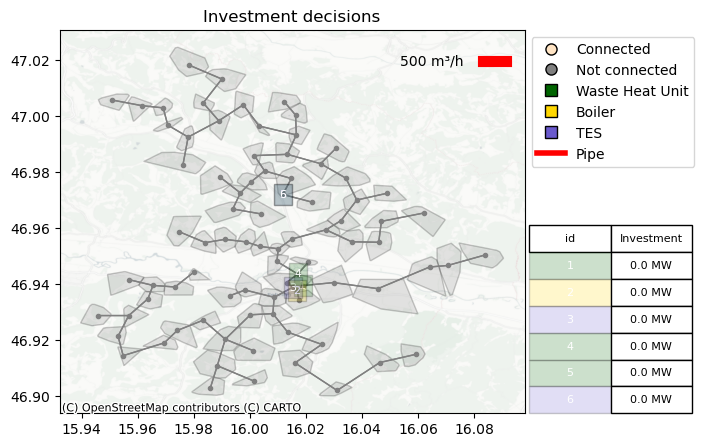

Done: saved investment decisions plot to disk
Done: saved time series plot to disk


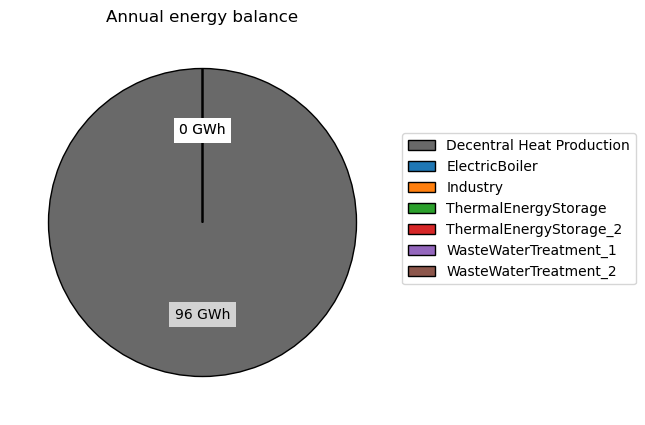

Done: saved time series plot to disk


c:\Users\Simon Malacek\Code\UrbanHeatOpt\visualisation.py:394: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  loc_df_energy_balance = df_energy_balance.resample(time_invervall).sum()/1e3


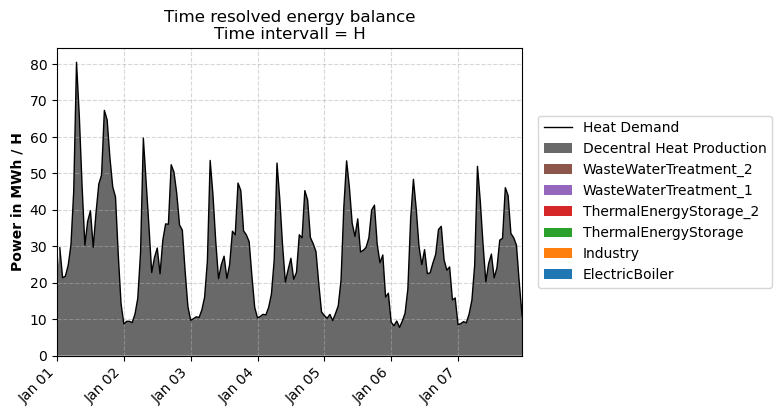

Done: saved time resolved energy balance plot to disk


In [9]:
# plot the results
visualisation.make_basic_plots(case_study_name, scenario_name, time_invervall= 'H', start_hour= 0, duration_hours= 167)